# Search for extreme changes Micro age groups

In [1]:
import cooler
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
import seaborn as sns

In [2]:
downsample_dir = Path(
    "/tscc/projects/ps-epigen/users/biy022/scmethylhic/"
    "human_hippocampus/snm3c/Combined/hic/downsampled"
)

In [3]:
subclass = "Micro"
raw_100k_dir = downsample_dir / subclass
baseline_dataset = cooler.Cooler(str(raw_100k_dir / f"{subclass}_20-40.mcool::/resolutions/100000"))

## Age group 2 vs 1

In [4]:
contrast_label = "age2vs1"

In [5]:
## load dataset
contrast_dataset = cooler.Cooler(str(raw_100k_dir / f"{subclass}_40-60.mcool::/resolutions/100000"))

In [6]:
baseline_dataset_cis_list = list()
for chrname in baseline_dataset.chromnames:
    baseline_dataset_cis_list.append(baseline_dataset.matrix(balance=False).fetch(chrname))
baseline_dataset_cis = linalg.block_diag(*baseline_dataset_cis_list)

contrast_dataset_cis_list = list()
for chrname in contrast_dataset.chromnames:
    contrast_dataset_cis_list.append(contrast_dataset.matrix(balance=False).fetch(chrname))
contrast_dataset_cis = linalg.block_diag(*contrast_dataset_cis_list)

In [7]:
# micro_diff = micro2_dataset.matrix(balance=False)[:] - micro1_dataset.matrix(balance=False)[:]
contrast_diff = np.triu(contrast_dataset_cis - baseline_dataset_cis)

In [8]:
contrast_diff_flattened = contrast_diff.flatten()
contrast_diff_nonzero = contrast_diff_flattened[contrast_diff_flattened != 0]
counts, edges = np.histogram(contrast_diff_flattened, bins=100000)

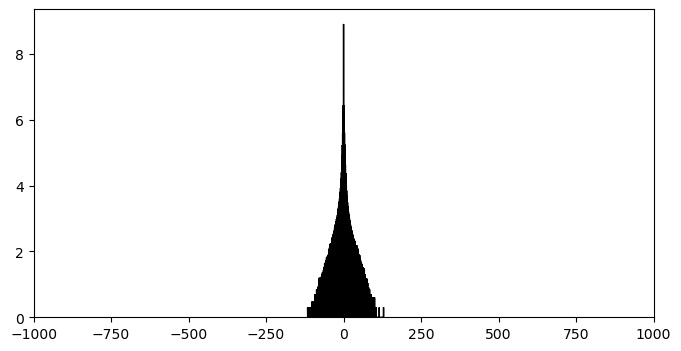

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(4)
ax.stairs(np.log10(counts + 1), edges, ec="black")
ax.set_xlim((-1000, 1000))

fig.savefig(
    f"/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus"
    f"/snm3c/Combined/hic/figures/downsample_micro_subtypes_diff/{subclass}_{contrast_label}_raw_100k_diff_dist.pdf",
    dpi=200,
    format="pdf"
)

### Higher

In [10]:
contrast_diff_nonzero_h = contrast_diff_nonzero[contrast_diff_nonzero > 0]
higher_cutoff = np.percentile(contrast_diff_flattened, (1 - 5e-6) * 100)

In [11]:
higher_cutoff

30.0

In [12]:
select_xs_h, select_ys_h = np.where(np.triu(contrast_diff) > higher_cutoff)

In [13]:
# Create bed files
select_xh_gbins = baseline_dataset.bins()[:].iloc[select_xs_h].reset_index(drop=True)
select_yh_gbins = baseline_dataset.bins()[:].iloc[select_ys_h].reset_index(drop=True)
select_xh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xh_gbins.shape[0])]
select_yh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yh_gbins.shape[0])]

cis_filter = select_xh_gbins.chrom == select_yh_gbins.chrom
distance_filter = np.abs(select_xh_gbins.start - select_yh_gbins.start) < 1e7

select_xh_gbins = select_xh_gbins[cis_filter & distance_filter]
select_yh_gbins = select_yh_gbins[cis_filter & distance_filter]

In [14]:
select_xh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_5e-6_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [15]:
select_yh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_5e-6_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [16]:
## Move to bash to sort, merge and filter fragments

In [17]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_5e-6_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [18]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_5e-6_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [19]:
## Create all files in command line before bgzip
## A test for correctness

In [20]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [21]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [22]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_h[sorted(selected_indices)],
    "bin2_id": select_ys_h[sorted(selected_indices)]
})

In [23]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [24]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_h_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [25]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_h_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

### Lower

In [26]:
contrast_diff_nonzero_l = contrast_diff_nonzero[contrast_diff_nonzero < 0]
lower_cutoff = np.percentile(contrast_diff_flattened, 5e-6 * 100)

In [27]:
lower_cutoff

-34.0

In [28]:
select_xs_l, select_ys_l = np.where(np.triu(contrast_diff) < lower_cutoff)

In [29]:
# Create bed files
select_xl_gbins = baseline_dataset.bins()[:].iloc[select_xs_l].reset_index(drop=True)
select_yl_gbins = baseline_dataset.bins()[:].iloc[select_ys_l].reset_index(drop=True)
select_xl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xl_gbins.shape[0])]
select_yl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yl_gbins.shape[0])]

cis_filter = select_xl_gbins.chrom == select_yl_gbins.chrom
distance_filter = np.abs(select_xl_gbins.start - select_yl_gbins.start) < 1e7

select_xl_gbins = select_xl_gbins[cis_filter & distance_filter]
select_yl_gbins = select_yl_gbins[cis_filter & distance_filter]

In [30]:
select_xl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_5e-6_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [31]:
select_yl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_5e-6_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [32]:
## Move to bash to sort, merge and filter fragments

In [33]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_5e-6_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [34]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_5e-6_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [35]:
## Create all files in command line before bgzip
## A test for correctness

In [36]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [37]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [38]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_l[sorted(selected_indices)],
    "bin2_id": select_ys_l[sorted(selected_indices)]
})

In [39]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [40]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_l_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [41]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_l_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

## Age group 3 vs 1

In [42]:
contrast_label = "age3vs1"

In [43]:
## load dataset
contrast_dataset = cooler.Cooler(str(raw_100k_dir / f"{subclass}_60-80.mcool::/resolutions/100000"))

In [44]:
baseline_dataset_cis_list = list()
for chrname in baseline_dataset.chromnames:
    baseline_dataset_cis_list.append(baseline_dataset.matrix(balance=False).fetch(chrname))
baseline_dataset_cis = linalg.block_diag(*baseline_dataset_cis_list)

contrast_dataset_cis_list = list()
for chrname in contrast_dataset.chromnames:
    contrast_dataset_cis_list.append(contrast_dataset.matrix(balance=False).fetch(chrname))
contrast_dataset_cis = linalg.block_diag(*contrast_dataset_cis_list)

In [45]:
# micro_diff = micro2_dataset.matrix(balance=False)[:] - micro1_dataset.matrix(balance=False)[:]
contrast_diff = np.triu(contrast_dataset_cis - baseline_dataset_cis)

In [46]:
contrast_diff_flattened = contrast_diff.flatten()
contrast_diff_nonzero = contrast_diff_flattened[contrast_diff_flattened != 0]
counts, edges = np.histogram(contrast_diff_flattened, bins=100000)

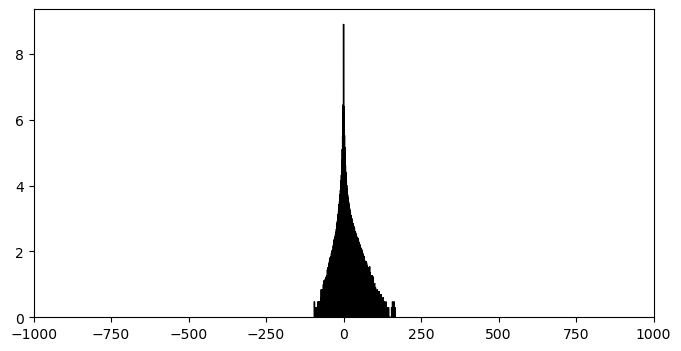

In [47]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(4)
ax.stairs(np.log10(counts + 1), edges, ec="black")
ax.set_xlim((-1000, 1000))

fig.savefig(
    f"/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus"
    f"/snm3c/Combined/hic/figures/downsample_micro_subtypes_diff/{subclass}_{contrast_label}_raw_100k_diff_dist.pdf",
    dpi=200,
    format="pdf"
)

### Higher

In [48]:
contrast_diff_nonzero_h = contrast_diff_nonzero[contrast_diff_nonzero > 0]
higher_cutoff = np.percentile(contrast_diff_flattened, (1 - 5e-6) * 100)

In [49]:
higher_cutoff

44.0

In [50]:
select_xs_h, select_ys_h = np.where(np.triu(contrast_diff) > higher_cutoff)

In [51]:
# Create bed files
select_xh_gbins = baseline_dataset.bins()[:].iloc[select_xs_h].reset_index(drop=True)
select_yh_gbins = baseline_dataset.bins()[:].iloc[select_ys_h].reset_index(drop=True)
select_xh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xh_gbins.shape[0])]
select_yh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yh_gbins.shape[0])]

cis_filter = select_xh_gbins.chrom == select_yh_gbins.chrom
distance_filter = np.abs(select_xh_gbins.start - select_yh_gbins.start) < 1e7

select_xh_gbins = select_xh_gbins[cis_filter & distance_filter]
select_yh_gbins = select_yh_gbins[cis_filter & distance_filter]

In [52]:
select_xh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_5e-6_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [53]:
select_yh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_5e-6_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [54]:
## Move to bash to sort, merge and filter fragments

In [57]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_5e-6_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [56]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_5e-6_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [58]:
## Create all files in command line before bgzip
## A test for correctness

In [59]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [60]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [61]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_h[sorted(selected_indices)],
    "bin2_id": select_ys_h[sorted(selected_indices)]
})

In [62]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [63]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_h_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [64]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_h_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

### Lower

In [65]:
contrast_diff_nonzero_l = contrast_diff_nonzero[contrast_diff_nonzero < 0]
lower_cutoff = np.percentile(contrast_diff_flattened, 5e-6 * 100)

In [66]:
lower_cutoff

-23.0

In [67]:
select_xs_l, select_ys_l = np.where(np.triu(contrast_diff) < lower_cutoff)

In [68]:
# Create bed files
select_xl_gbins = baseline_dataset.bins()[:].iloc[select_xs_l].reset_index(drop=True)
select_yl_gbins = baseline_dataset.bins()[:].iloc[select_ys_l].reset_index(drop=True)
select_xl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xl_gbins.shape[0])]
select_yl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yl_gbins.shape[0])]

cis_filter = select_xl_gbins.chrom == select_yl_gbins.chrom
distance_filter = np.abs(select_xl_gbins.start - select_yl_gbins.start) < 1e7

select_xl_gbins = select_xl_gbins[cis_filter & distance_filter]
select_yl_gbins = select_yl_gbins[cis_filter & distance_filter]

In [69]:
select_xl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_5e-6_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [70]:
select_yl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_5e-6_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [71]:
## Move to bash to sort, merge and filter fragments

In [72]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_5e-6_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [73]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_5e-6_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [74]:
## Create all files in command line before bgzip
## A test for correctness

In [75]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_5e-6_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_5e-6_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [76]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [77]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_l[sorted(selected_indices)],
    "bin2_id": select_ys_l[sorted(selected_indices)]
})

In [78]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [79]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_l_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [80]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_5e-6_1e7_l_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

## Age group 4 vs 1

In [4]:
contrast_label = "age4vs1"

In [5]:
## load dataset
contrast_dataset = cooler.Cooler(str(raw_100k_dir / f"{subclass}_80-100.mcool::/resolutions/100000"))

In [6]:
baseline_dataset_cis_list = list()
for chrname in baseline_dataset.chromnames:
    baseline_dataset_cis_list.append(baseline_dataset.matrix(balance=False).fetch(chrname))
baseline_dataset_cis = linalg.block_diag(*baseline_dataset_cis_list)

contrast_dataset_cis_list = list()
for chrname in contrast_dataset.chromnames:
    contrast_dataset_cis_list.append(contrast_dataset.matrix(balance=False).fetch(chrname))
contrast_dataset_cis = linalg.block_diag(*contrast_dataset_cis_list)

In [7]:
# micro_diff = micro2_dataset.matrix(balance=False)[:] - micro1_dataset.matrix(balance=False)[:]
contrast_diff = np.triu(contrast_dataset_cis - baseline_dataset_cis)

In [8]:
contrast_diff_flattened = contrast_diff.flatten()
contrast_diff_nonzero = contrast_diff_flattened[contrast_diff_flattened != 0]
counts, edges = np.histogram(contrast_diff_flattened, bins=100000)

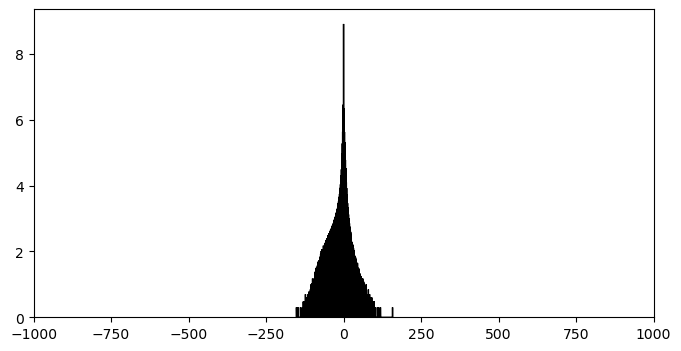

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(4)
ax.stairs(np.log10(counts + 1), edges, ec="black")
ax.set_xlim((-1000, 1000))

fig.savefig(
    f"/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus"
    f"/snm3c/Combined/hic/figures/downsample_micro_subtypes_diff/{subclass}_{contrast_label}_raw_100k_diff_dist.pdf",
    dpi=200,
    format="pdf"
)

### Higher

In [10]:
contrast_diff_nonzero_h = contrast_diff_nonzero[contrast_diff_nonzero > 0]
higher_cutoff = np.percentile(contrast_diff_nonzero_h, (1 - 65e-5) * 100)

In [11]:
higher_cutoff

24.0

In [12]:
select_xs_h, select_ys_h = np.where(np.triu(contrast_diff) > higher_cutoff)

In [13]:
# Create bed files
select_xh_gbins = baseline_dataset.bins()[:].iloc[select_xs_h].reset_index(drop=True)
select_yh_gbins = baseline_dataset.bins()[:].iloc[select_ys_h].reset_index(drop=True)
select_xh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xh_gbins.shape[0])]
select_yh_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yh_gbins.shape[0])]

cis_filter = select_xh_gbins.chrom == select_yh_gbins.chrom
distance_filter = np.abs(select_xh_gbins.start - select_yh_gbins.start) < 1e7

select_xh_gbins = select_xh_gbins[cis_filter & distance_filter]
select_yh_gbins = select_yh_gbins[cis_filter & distance_filter]

In [14]:
select_xh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_65e-5_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [15]:
select_yh_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_65e-5_1e7_h.bed",
    sep="\t",
    header=False,
    index=False
)

In [16]:
## Move to bash to sort, merge and filter fragments

In [17]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_65e-5_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [18]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_h.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_h.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_h.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_65e-5_1e7_h.large.complete.bed",
    sep="\t", header=False, index=False
)

In [19]:
## Create all files in command line before bgzip
## A test for correctness

In [20]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_h.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [21]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [22]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_h[sorted(selected_indices)],
    "bin2_id": select_ys_h[sorted(selected_indices)]
})

In [23]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [24]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_65e-5_1e7_h_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [25]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_65e-5_1e7_h_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

### Lower

In [26]:
contrast_diff_nonzero_l = contrast_diff_nonzero[contrast_diff_nonzero < 0]
lower_cutoff = np.percentile(contrast_diff_nonzero_l, 65e-5 * 100)

In [27]:
lower_cutoff

-57.0

In [28]:
select_xs_l, select_ys_l = np.where(np.triu(contrast_diff) < lower_cutoff)

In [29]:
# Create bed files
select_xl_gbins = baseline_dataset.bins()[:].iloc[select_xs_l].reset_index(drop=True)
select_yl_gbins = baseline_dataset.bins()[:].iloc[select_ys_l].reset_index(drop=True)
select_xl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_xl_gbins.shape[0])]
select_yl_gbins.loc[:, "name"] = ["N" + str(i) for i in range(0, select_yl_gbins.shape[0])]

cis_filter = select_xl_gbins.chrom == select_yl_gbins.chrom
distance_filter = np.abs(select_xl_gbins.start - select_yl_gbins.start) < 1e7

select_xl_gbins = select_xl_gbins[cis_filter & distance_filter]
select_yl_gbins = select_yl_gbins[cis_filter & distance_filter]

In [30]:
select_xl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"L_100k_65e-5_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [31]:
select_yl_gbins.iloc[:, [0,1,2,4]].to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / f"R_100k_65e-5_1e7_l.bed",
    sep="\t",
    header=False,
    index=False
)

In [32]:
## Move to bash to sort, merge and filter fragments

In [33]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "L_100k_65e-5_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [34]:
## Sort, bedtools merge and filter in terminal
## Process left merged and filtered bed
L_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_l.large.bed",
    header=None, sep="\t"
)
L_large_bed.columns = ["chr", "start", "end", "names"]
L_orig_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_l.bed",
    header=None, sep="\t"
)
L_orig_bed.columns = ["chr", "start", "end", "names"]
R_large_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_l.large.bed",
    header=None, sep="\t"
)
R_large_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_large_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]
L_all_names = [xx.split(",") for xx in L_large_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]
L_add_names = [xx for xx in R_all_names if not xx in L_all_names]
L_new_large_bed = pd.concat([L_large_bed, L_orig_bed[L_orig_bed["names"].isin(L_add_names)]])
L_new_large_bed.to_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label /  "R_100k_65e-5_1e7_l.large.complete.bed",
    sep="\t", header=False, index=False
)

In [35]:
## Create all files in command line before bgzip
## A test for correctness

In [36]:
## A test for correctness
L_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "L_100k_65e-5_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
L_final_bed.columns = ["chr", "start", "end", "names"]
L_all_names = [xx.split(",") for xx in L_final_bed["names"]]
L_all_names = [xx for x in L_all_names for xx in x]

R_final_bed = pd.read_csv(
    downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "R_100k_65e-5_1e7_l.large.complete.merged.bed",
    header=None, sep="\t")
R_final_bed.columns = ["chr", "start", "end", "names"]
R_all_names = [xx.split(",") for xx in R_final_bed["names"]]
R_all_names = [xx for x in R_all_names for xx in x]

In [37]:
len(set(L_all_names)) == len(set(R_all_names))

True

In [38]:
selected_indices = [int(xx[1:]) for xx in set(R_all_names)]
selected_df = pd.DataFrame({
    "bin1_id": select_xs_l[sorted(selected_indices)],
    "bin2_id": select_ys_l[sorted(selected_indices)]
})

In [39]:
baseline_pixels_selected = baseline_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])
contrast_pixels_selected = contrast_dataset.pixels()[:].merge(selected_df, on=["bin1_id", "bin2_id"])

In [40]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_65e-5_1e7_l_baseline.cool"),
    bins = baseline_dataset.bins()[:],
    pixels = baseline_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)

In [41]:
cooler.create_cooler(
    str(downsample_dir / subclass / "large_diff_coordinates" / contrast_label / "Merged_100k_65e-5_1e7_l_contrast.cool"),
    bins = contrast_dataset.bins()[:],
    pixels = contrast_pixels_selected,
    ordered = False,
    dtypes={'count': np.float32}
)